<a href="https://colab.research.google.com/github/SiraHaruethaipree/Text_Classification_Thai_news/blob/main/text_classification_news_wangchanberta_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification news wangchanberta

Notebook นี้จัดทำขึ้นเพื่อวัตถุประสงค์ที่ต้องการจำแนกข่าว(Text classification) จากชุดข้อมูลที่เก็บมาได้จากการ Web scraping ของเว็บไซต์ ใช้ชุดข้อมูลที่เก็บมาจากเว็บไซต์ https://www.thaipbs.or.th/home โดยเริ่มเก็บข้อมูลตั้งแต่วันที่ 3 เมษายน 2566 ย้อนหลังเป็นจำนวนอย่างละ 250 ข่าว 

เทคนิควิธีการทำนายโมเดลจะใช้ Large Language model ของ wangchanberta ที่เป็น pre-train ที่ผ่านการฝึกผ่านชุดข้อมูลภาษาไทยที่มีขนาด 78.5 GB ด้วยเทคนิคคล้ายกับ BERT และ RoBERTa ที่ใช้เทคนิคการ Mask language modeling คือใช้การสุ่มคำแทนที่ด้วย mask token <mask> 15% ในชุดลำดับอินพุตของเอกสาร ภายใน 15 เปอร์เซ็นต์จะถูกแทนที่ด้วย Mask Token ที่จะถูกแทนสัญลักษณ์ด้วย [MASK] คิดเป็นจำนวน 80 เปอร์เซ็นต์ สุ่มคำอื่นแทนที่เป็นจำนวน 10 เปอร์เซ็นต์เพื่อช่วยให้โมเดลเรียนรู้จากการพึ่งพาคำทังหมดที่อยู่ภายในบริบท มากกว่าการพึ่งพาแค่คำใดคำหนึ่ง และไม่มีการเปลี่ยนแปลงคำนั้นๆอีก 10 เปอร์เซ็นต์เพื่อรักษาบริบทโดยรวมเมื่อมีคำสำคัญบางคำถูก Mask แสดงตัวอย่างในรูปด้านล่าง


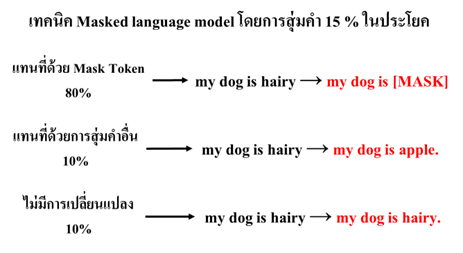

ในส่วนของ pre-train ที่เลือกใช้จะใช้ wangchanberta-base-att-spm-uncased ที่มีขนาดคำศัพท์เท่ากับ 25000 และมีขนาดโมเดลพารามิเตอร์อยู่ที่ 382 ล้านพารามิเตอร์ ชุด pre-train จะถูกดึงมาใช้จาก huggingface( https://huggingface.co/airesearch/wangchanberta-base-att-spm-uncased)  

# Install library 

In [ ]:
! pip install ray[tune]

In [ ]:
! pip install pythainlp

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

# Import library

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pythainlp import word_tokenize
from sklearn.model_selection import train_test_split
from pythainlp.corpus import thai_stopwords
from gensim.models import Word2Vec
import torch


from wordcloud import WordCloud
from collections import defaultdict
import re
import numpy as np

เนื่องจากข้อมูลเป็นภาษาไทย การจะพล็อตกราฟออกมาให้เป็นภาษาไทยของ matplotlib จะต้องทำการดาวน์โหลด front ของภาษาไทย

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [ ]:
mpl.font_manager.fontManager.addfont('/kaggle/working/thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

# Import Dataset

ข้อมูลที่ใช้จะเป็นข้อมูลข่าวที่ประกอบไปด้วย ข่าว การเมือง, กีฬา, วิทยาศาสตร์เทคโนโลยี, อาชญากรรม, เศรษฐกิจ ที่ใช้ในการจำแนกประเภท โดยข้อมูลเป็นข้อมูลที่เก็บจากการ web scraping จากเว็บไซต์ข่าวของ ThaiPBS

In [ ]:
df = pd.read_csv("/kaggle/input/thai-news-pbs-from-scrap/thai_news.csv", encoding = "utf-8")

In [ ]:
df.head()

,Unnamed: 0,title,context,label
0,0,วันแรก รับสมัคร ส.ส.แบ่งเขต กทม.เป็นไปอย่างเรี...,วันแรก รับสมัครเลือกตั้ง ส.ส.แบ่งเขตวันแรกคึกค...,การเมือง
1,1,"""โรม"" นำทีมว่าที่ผู้สมัคร ส.ส.นครศรีฯ ทั้ง 10 ...",ก้าวไกล ดาวกระจายสมัคร ส.ส.ทั่วประเทศ บรรยากาศ...,การเมือง
2,2,"""พิธา"" นำทีมผู้สมัคร ส.ส. 33 เขต กทม.ขึ้นรถปรา...",ส.ส.ก้าวไกล ขึ้นรถปราศรัยหลังจับเบอร์ผู้สมัคร ...,การเมือง
3,3,"""บิ๊กตู่"" เปิดใจไม่ลงปาร์ตี้ลิสต์เหตุงานเยอะ อ...",พล.อ.ประยุทธ์ ย้ำไม่จับมือทุกพรรค ไม่มีเงื่อนไ...,การเมือง
4,4,"กกต.เตือน ส.ส. ได้เบอร์ ""อย่าแห่หาเสียง"" 7 เม....",กกต.พอใจรับสมัครส.ส.วันแรก รอตรวจคุณสมบัติอีก ...,การเมือง


In [ ]:
df.shape

(1183, 4)

<AxesSubplot: xlabel='label', ylabel='count'>

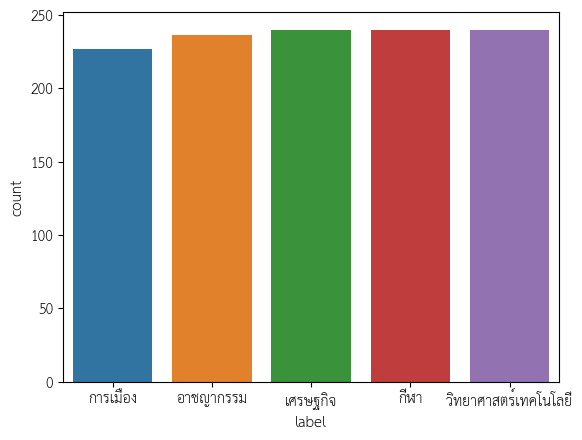

In [ ]:
sns.countplot(x=df["label"])

ภายในข้อมูลจะประกอบไปด้วย 
* title : ชื่อเรื่อง
* context : เนื้อหาของข่าว
* label : ประเภทของข่าวที่จะใช้ในการทำนาย

และมีขนาดของข้อมูลอยู่ที่ 1183 แถว โดยแต่ละ label จะมีจำนวนข้อมูลเฉี่ยนอยู่ที่ 250 คำโดยประมาณ

# EDA Thai News dataset

ในส่วนนี้จะทำการ Exploratory Data Analysis สำรวจและวิเคราะห์ข้อมูลจากที่มีอยู่โดยทำการ visualize ให้ได้เห็น insight มากขึ้น

In [ ]:
text_politics = " ".join(review for review in df["context"][df["label"] == "การเมือง"])
text_crime = " ".join(review for review in df["context"][df["label"] == "อาชญากรรม"])
text_economic = " ".join(review for review in df["context"][df["label"] == "เศรษฐกิจ"])
text_sport = " ".join(review for review in df["context"][df["label"] == "กีฬา"])
text_tech = " ".join(review for review in df["context"][df["label"] == "วิทยาศาสตร์เทคโนโลยี"])

### Wordcloud politics

Wordcloud เป็นเครื่องมือในการทำให้สามารถแสดงความถี่ของคำในรูปแบบของตัวอักษรที่ออกมาได้ ยิ่งถ้ามีความใหญ่ของตัวอักษรแสดงว่าข้อมูลนั้นพบเจอมากในข้อมูล โดยจะแบ่งเป็นรูปแต่ละประเภทจำแนกกันไปตามประเภทข่าว

In [ ]:
#สร้าง stopword ที่ไม่มีความหมายต่อประโยคออกไป เพื่อใฟ้ง่ายต่อการแสดงกราฟ
stopwords = list(thai_stopwords())
add_stopword = ["nan", "-", "_", "", " ", ")", "(", "“", "”"]
stopwords = stopwords + add_stopword

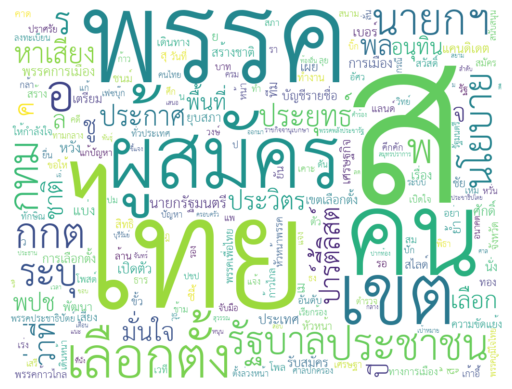

In [ ]:
wordcloud_politics = WordCloud(font_path='/kaggle/working/thsarabunnew-webfont.ttf',
                      stopwords = stopwords,
                      background_color="white",
                      width=1024, 
                      height=768, 
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+").generate(' '.join(word_tokenize(text_politics,engine = "newmm")))
plt.imshow(wordcloud_politics, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

### Wordcloud crime

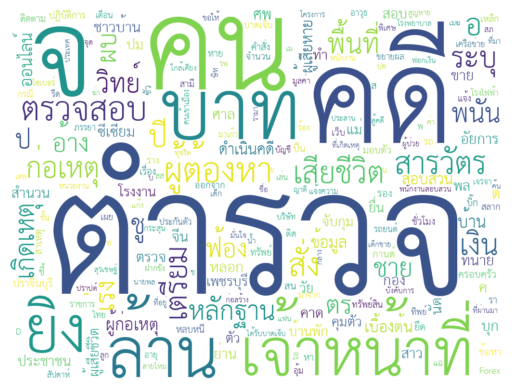

In [ ]:
wordcloud_crime = WordCloud(font_path='/kaggle/working/thsarabunnew-webfont.ttf',
                      stopwords = stopwords,
                      background_color="white",
                      width=1024, 
                      height=768, 
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+").generate(' '.join(word_tokenize(text_crime,engine = "newmm")))
plt.imshow(wordcloud_crime, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

### Wordcloud economic

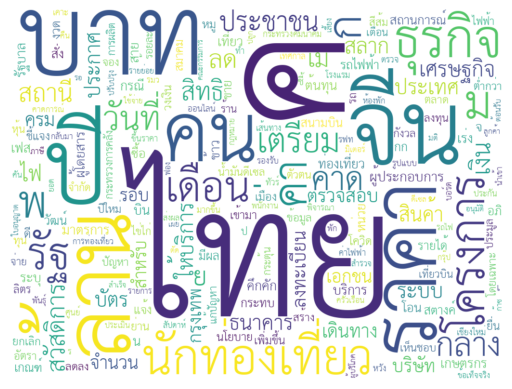

In [ ]:
wordcloud_economic = WordCloud(font_path='/kaggle/working/thsarabunnew-webfont.ttf',
                      stopwords = stopwords,
                      background_color="white",
                      width=1024, 
                      height=768, 
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+").generate(' '.join(word_tokenize(text_economic,engine = "newmm")))
plt.imshow(wordcloud_economic, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

### Wordcloud sport

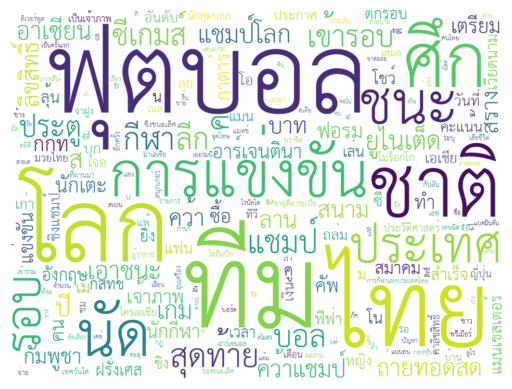

In [ ]:
wordcloud_sport = WordCloud(font_path='/kaggle/working/thsarabunnew-webfont.ttf',
                      stopwords = stopwords,
                      background_color="white",
                      width=1024, 
                      height=768, 
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+").generate(' '.join(word_tokenize(text_sport,engine = "newmm")))
plt.imshow(wordcloud_sport, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

### Wordcloud technology

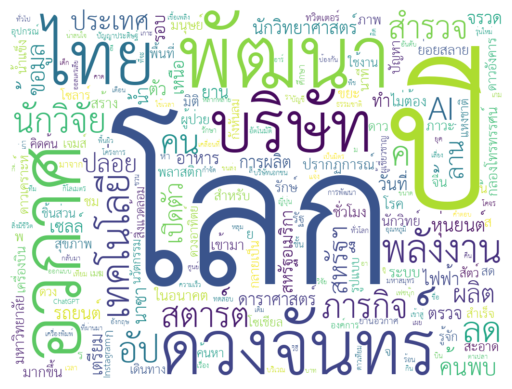

In [ ]:
wordcloud_tech = WordCloud(font_path='/kaggle/working/thsarabunnew-webfont.ttf',
                      stopwords = stopwords,
                      background_color="white",
                      width=1024, 
                      height=768, 
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+").generate(' '.join(word_tokenize(text_tech,engine = "newmm")))
plt.imshow(wordcloud_tech, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

ในลำดับถัดไปจะเป็นการแสดงความถี่ของคำ ที่พบเจอในแต่ละหมวดหมู่ของข่าวโดยแบ่งประเภทเป็น unigram และ bigram 

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in word_tokenize(text.strip().lower().replace('"', ''),engine = "newmm") if token != '' if token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]



# Unigrams
politics_unigrams = defaultdict(int)
crime_unigrams = defaultdict(int)
economic_unigrams = defaultdict(int)
sport_unigrams = defaultdict(int)
tech_unigrams = defaultdict(int)


for news in df["context"][df["label"] == "การเมือง"]:
    for word in generate_ngrams(news):
        politics_unigrams[word] += 1
        
for news in df["context"][df["label"] == "อาชญากรรม"]:
    for word in generate_ngrams(news):
        crime_unigrams[word] += 1

for news in df["context"][df["label"] == "เศรษฐกิจ"]:
    for word in generate_ngrams(news):
        economic_unigrams[word] += 1     

for news in df["context"][df["label"] == "กีฬา"]:
    for word in generate_ngrams(news):
        sport_unigrams[word] += 1

for news in df["context"][df["label"] == "วิทยาศาสตร์เทคโนโลยี"]:
    for word in generate_ngrams(news):
        tech_unigrams[word] += 1   
        
df_politics_unigrams = pd.DataFrame(sorted(politics_unigrams.items(), key=lambda x: x[1])[::-1])
df_crime_unigrams = pd.DataFrame(sorted(crime_unigrams.items(), key=lambda x: x[1])[::-1])
df_economic_unigrams = pd.DataFrame(sorted(economic_unigrams.items(), key=lambda x: x[1])[::-1])
df_sport_unigrams = pd.DataFrame(sorted(sport_unigrams.items(), key=lambda x: x[1])[::-1])
df_tech_unigrams = pd.DataFrame(sorted(tech_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
politics_bigrams = defaultdict(int)
crime_bigrams = defaultdict(int)
economic_bigrams = defaultdict(int)
sport_bigrams = defaultdict(int)
tech_bigrams = defaultdict(int)


for news in df["context"][df["label"] == "การเมือง"]:
    for word in generate_ngrams(news, n_gram=2):
        politics_bigrams[word] += 1
        
for news in df["context"][df["label"] == "อาชญากรรม"]:
    for word in generate_ngrams(news, n_gram=2):
        crime_bigrams[word] += 1

for news in df["context"][df["label"] == "เศรษฐกิจ"]:
    for word in generate_ngrams(news, n_gram=2):
        economic_bigrams[word] += 1     

for news in df["context"][df["label"] == "กีฬา"]:
    for word in generate_ngrams(news, n_gram=2):
        sport_bigrams[word] += 1

for news in df["context"][df["label"] == "วิทยาศาสตร์เทคโนโลยี"]:
    for word in generate_ngrams(news, n_gram=2):
        tech_bigrams[word] += 1   
        
df_politics_bigrams = pd.DataFrame(sorted(politics_bigrams.items(), key=lambda x: x[1])[::-1])
df_crime_bigrams = pd.DataFrame(sorted(crime_bigrams.items(), key=lambda x: x[1])[::-1])
df_economic_bigrams = pd.DataFrame(sorted(economic_bigrams.items(), key=lambda x: x[1])[::-1])
df_sport_bigrams = pd.DataFrame(sorted(sport_bigrams.items(), key=lambda x: x[1])[::-1])
df_tech_bigrams = pd.DataFrame(sorted(tech_bigrams.items(), key=lambda x: x[1])[::-1])

### Frequency unigram plot 

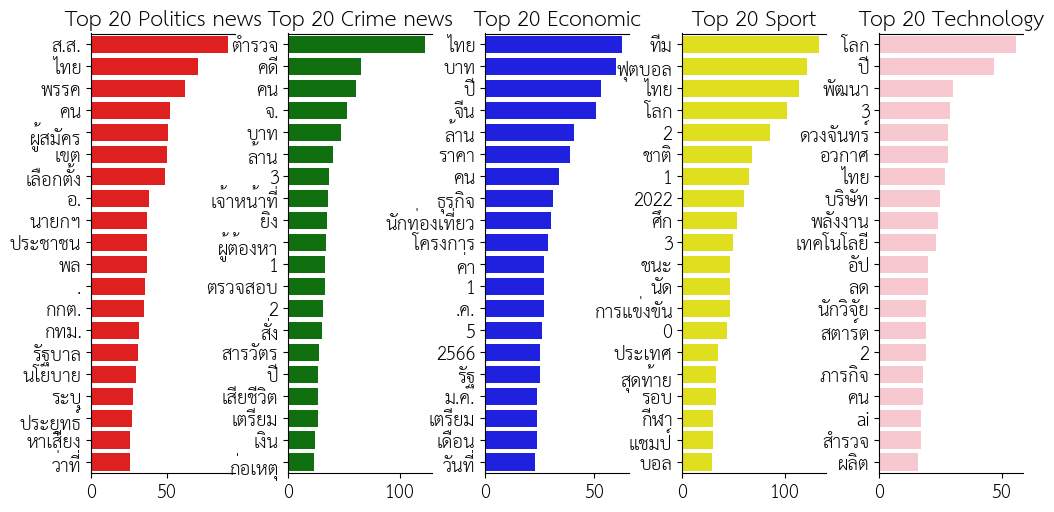

In [ ]:
N = 20
fig, axes = plt.subplots(ncols=5, figsize=(10, 5), dpi=100)
plt.tight_layout()

sns.barplot(y=df_politics_unigrams[0].values[:N], x=df_politics_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_crime_unigrams[0].values[:N], x=df_crime_unigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_economic_unigrams[0].values[:N], x=df_economic_unigrams[1].values[:N], ax=axes[2], color='blue')
sns.barplot(y=df_sport_unigrams[0].values[:N], x=df_sport_unigrams[1].values[:N], ax=axes[3], color='yellow')
sns.barplot(y=df_tech_unigrams[0].values[:N], x=df_tech_unigrams[1].values[:N], ax=axes[4], color='pink')

for i in range(5):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} Politics news', fontsize=15)
axes[1].set_title(f'Top {N} Crime news', fontsize=15)
axes[2].set_title(f'Top {N} Economic', fontsize=15)
axes[3].set_title(f'Top {N} Sport', fontsize=15)
axes[4].set_title(f'Top {N} Technology', fontsize=15)

plt.show()

ผลแสดงกราฟความถี่ของคำ unigram ภายในเอกสารของแต่ละหมวดหมู่

### Frequency bigram plot 

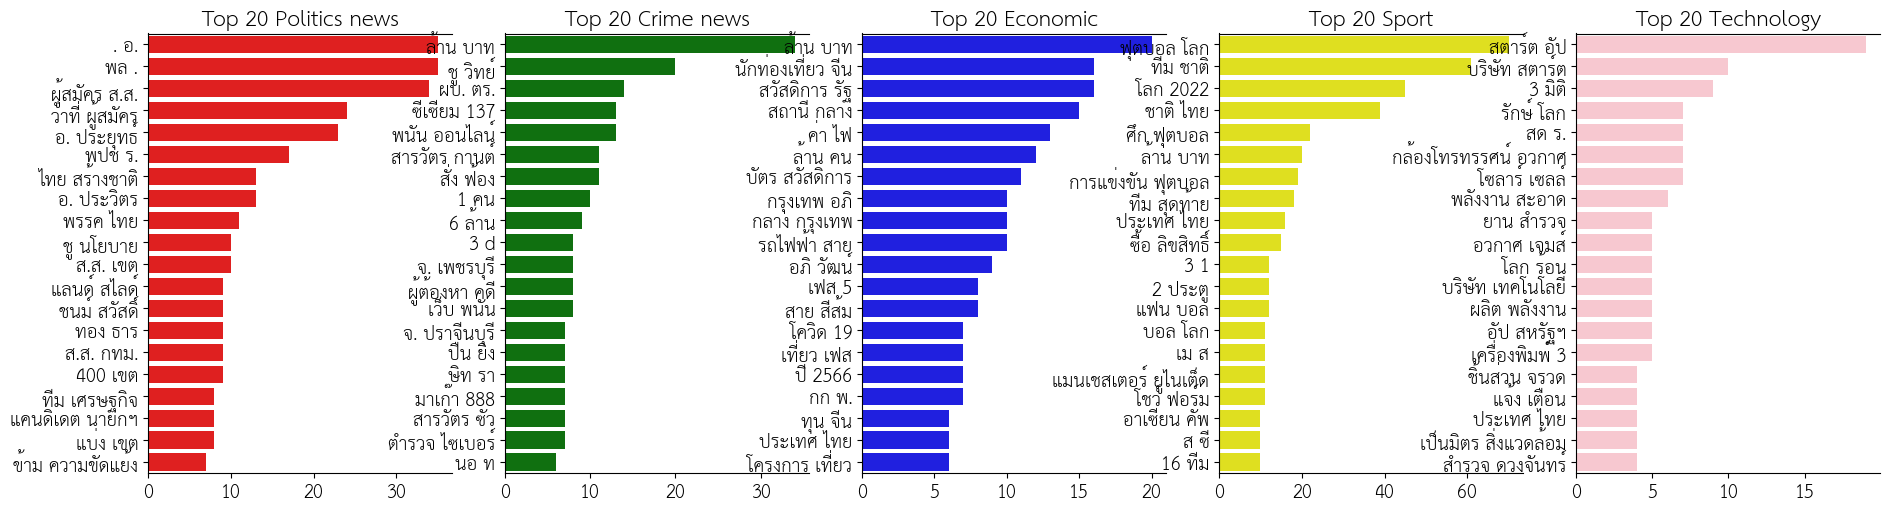

In [ ]:
N = 20
fig, axes = plt.subplots(ncols=5, figsize=(18, 5), dpi=100)
plt.tight_layout()

sns.barplot(y=df_politics_bigrams[0].values[:N], x=df_politics_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_crime_bigrams[0].values[:N], x=df_crime_bigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_economic_bigrams[0].values[:N], x=df_economic_bigrams[1].values[:N], ax=axes[2], color='blue')
sns.barplot(y=df_sport_bigrams[0].values[:N], x=df_sport_bigrams[1].values[:N], ax=axes[3], color='yellow')
sns.barplot(y=df_tech_bigrams[0].values[:N], x=df_tech_bigrams[1].values[:N], ax=axes[4], color='pink')

for i in range(5):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} Politics news', fontsize=15)
axes[1].set_title(f'Top {N} Crime news', fontsize=15)
axes[2].set_title(f'Top {N} Economic', fontsize=15)
axes[3].set_title(f'Top {N} Sport', fontsize=15)
axes[4].set_title(f'Top {N} Technology', fontsize=15)

plt.show()

ผลแสดงกราฟความถี่ของคำ bigram ภายในเอกสารของแต่ละหมวดหมู่

# Label Encoding 

ในส่วนถัดมาจะทำการ label encoding เพื่อทำการเปลี่ยนรูปแบบ text label เป็นในรูปแบบของตัวเลข numeric 

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_encode']= label_encoder.fit_transform(df["label"])
df['label_encode'].unique()

array([0, 3, 4, 1, 2])

In [ ]:
df.head()

,Unnamed: 0,title,context,label,label_encode
0,0,วันแรก รับสมัคร ส.ส.แบ่งเขต กทม.เป็นไปอย่างเรี...,วันแรก รับสมัครเลือกตั้ง ส.ส.แบ่งเขตวันแรกคึกค...,การเมือง,0
1,1,"""โรม"" นำทีมว่าที่ผู้สมัคร ส.ส.นครศรีฯ ทั้ง 10 ...",ก้าวไกล ดาวกระจายสมัคร ส.ส.ทั่วประเทศ บรรยากาศ...,การเมือง,0
2,2,"""พิธา"" นำทีมผู้สมัคร ส.ส. 33 เขต กทม.ขึ้นรถปรา...",ส.ส.ก้าวไกล ขึ้นรถปราศรัยหลังจับเบอร์ผู้สมัคร ...,การเมือง,0
3,3,"""บิ๊กตู่"" เปิดใจไม่ลงปาร์ตี้ลิสต์เหตุงานเยอะ อ...",พล.อ.ประยุทธ์ ย้ำไม่จับมือทุกพรรค ไม่มีเงื่อนไ...,การเมือง,0
4,4,"กกต.เตือน ส.ส. ได้เบอร์ ""อย่าแห่หาเสียง"" 7 เม....",กกต.พอใจรับสมัครส.ส.วันแรก รอตรวจคุณสมบัติอีก ...,การเมือง,0


In [ ]:
label_class = list(enumerate(label_encoder.classes_))

# Train&Test split dataset 

แบ่งขนาด train และ test เพื่อใช้ในการฝึกและการทดสอบข้อมูลโดยจะแบ่ง train_set ให้มีขนาด 85% ของข้อมูลและ test set ให้มีขนาด 15% และใช้เฉพาะคอลัมน์ context ของชุดข้อมูลกับ label มาทำการ train 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["context"], df["label_encode"], test_size=0.15, random_state=42, shuffle = True)

In [ ]:
print("dimension of training set :",  X_train.shape)
print("dimension of testing set :",  X_test.shape)

dimension of training set : (1005,)
dimension of testing set : (178,)


In [ ]:
df_train = pd.DataFrame({"text" : X_train, "label" : y_train})
df_test = pd.DataFrame({"text" : X_test, "label": y_test})

In [ ]:
df_train.head()

,text,label
59,"“อนุทิน” ลุยหาเสียงช่วย ""เอกภพ"" มั่นใจปักธงเก้...",0
657,กระทรวงเกษตรและสหกรณ์ ฝังทำลายหมูเถื่อนของกลาง...,4
435,ผอ.เขตบางรัก ตรวจสอบเหตุเพลิงไหม้ บก.น.5 พบอาค...,3
937,จุฬาฯ-ม.ธรรมศาสตร์-นักวิชาการ ออกแถลงการณ์คัดค...,1
306,ผู้ว่าราชการจังหวัดเพชรบุรีสั่งเยียวยาครอบครัว...,3


# Data preprocessing text

ในส่วนนี้จะทำการทำความสะอาดข้อมูลของ text ดังขั้นตอนดังต่อไปนี้ 
- ลบช่องว่างเกิน, ลบสัญลักษณ์ต่างๆที่ไม่เกี่ยวข้อง
- ทำการ tokenize คำด้วย newmm ที่ตัดคำโดยใช้ dictionary-base 
- ทำการลบพวก stopword ออกจากข้อมูล
- ทำการ join ข้อความทั้งหมดเข้าด้วยกัน

หมายเหตุ เนื่องจาก wangchanberta เป็น pre-train ที่มีการทำ tokenize เป็นรูปแบบของโมเดลเองอยู่แต่ที่ต้อง tokenize แบบ dictionary-base เพื่อต้องการให้สามารถนำไปใช้กับ stopword ได้ 

In [ ]:
#Train set
df_train["context_clean1"] = df_train['text'].str.strip().str.lower().str.replace('"', '')
df_train["tokenize"] = df_train["context_clean1"].apply(lambda text: word_tokenize(text, engine = "newmm"))
df_train["Remove_stopword"] = df_train["tokenize"].apply(lambda text: [i for i in text if i not in stopwords])
df_train["Join_word"] = df_train["Remove_stopword"].apply(lambda text: ''.join(text))

#Test set
df_test["context_clean1"] = df_test['text'].str.strip().str.lower().str.replace('"', '')
df_test["tokenize"] = df_test["context_clean1"].apply(lambda text: word_tokenize(text, engine = "newmm"))
df_test["Remove_stopword"] = df_test["tokenize"].apply(lambda text: [i for i in text if i not in stopwords])
df_test["Join_word"] = df_test["Remove_stopword"].apply(lambda text: ''.join(text))

In [ ]:
df_train.head()

,text,label,context_clean1,tokenize,Remove_stopword,Join_word
59,"“อนุทิน” ลุยหาเสียงช่วย ""เอกภพ"" มั่นใจปักธงเก้...",0,“อนุทิน” ลุยหาเสียงช่วย เอกภพ มั่นใจปักธงเก้าอ...,"[“, อนุทิน, ”, , ลุย, หาเสียง, ช่วย, , เอกภพ...","[อนุทิน, ลุย, หาเสียง, เอกภพ, มั่นใจ, ปัก, ธง,...",อนุทินลุยหาเสียงเอกภพมั่นใจปักธงเก้าอี้สายไหมย...
657,กระทรวงเกษตรและสหกรณ์ ฝังทำลายหมูเถื่อนของกลาง...,4,กระทรวงเกษตรและสหกรณ์ ฝังทำลายหมูเถื่อนของกลาง...,"[กระทรวงเกษตรและสหกรณ์, , ฝัง, ทำลาย, หมู, เถ...","[กระทรวงเกษตรและสหกรณ์, ฝัง, ทำลาย, หมู, เถื่อ...",กระทรวงเกษตรและสหกรณ์ฝังทำลายหมูเถื่อนของกลางค...
435,ผอ.เขตบางรัก ตรวจสอบเหตุเพลิงไหม้ บก.น.5 พบอาค...,3,ผอ.เขตบางรัก ตรวจสอบเหตุเพลิงไหม้ บก.น.5 พบอาค...,"[ผอ., เขต, บาง, รัก, , ตรวจสอบ, เหตุ, เพลิงไห...","[ผอ., เขต, รัก, ตรวจสอบ, เพลิงไหม้, บก, ., น.,...",ผอ.เขตรักตรวจสอบเพลิงไหม้บก.น.5อาคารเสียหายรถย...
937,จุฬาฯ-ม.ธรรมศาสตร์-นักวิชาการ ออกแถลงการณ์คัดค...,1,จุฬาฯ-ม.ธรรมศาสตร์-นักวิชาการ ออกแถลงการณ์คัดค...,"[จุฬาฯ, -, ม., ธรรมศาสตร์, -, นักวิชาการ, , อ...","[จุฬาฯ, ม., ธรรมศาสตร์, นักวิชาการ, แถลงการณ์,...",จุฬาฯม.ธรรมศาสตร์นักวิชาการแถลงการณ์คัดค้านเงิ...
306,ผู้ว่าราชการจังหวัดเพชรบุรีสั่งเยียวยาครอบครัว...,3,ผู้ว่าราชการจังหวัดเพชรบุรีสั่งเยียวยาครอบครัว...,"[ผู้ว่าราชการจังหวัด, เพชรบุรี, สั่ง, เยียวยา,...","[ผู้ว่าราชการจังหวัด, เพชรบุรี, สั่ง, เยียวยา,...",ผู้ว่าราชการจังหวัดเพชรบุรีสั่งเยียวยาครอบครัว...


In [ ]:
df_test.head()

,text,label,context_clean1,tokenize,Remove_stopword,Join_word
803,“มาดามแป้ง” นวลพรรณ ล่ำซำ ผู้จัดการทีมชาติไทย ...,1,“มาดามแป้ง” นวลพรรณ ล่ำซำ ผู้จัดการทีมชาติไทย ...,"[“, มาดาม, แป้ง, ”, , นวล, พรรณ, , ล่ำ, ซำ, ...","[มาดาม, แป้ง, นวล, พรรณ, ล่ำ, ซำ, ผู้จัดการ, ท...",มาดามแป้งนวลพรรณล่ำซำผู้จัดการทีมชาติไทยอัดฉีด...
1135,สถาบันวิจัยดาราศาสตร์แห่งชาติ ชวนชม “ดาวพฤหัสบ...,2,สถาบันวิจัยดาราศาสตร์แห่งชาติ ชวนชม “ดาวพฤหัสบ...,"[สถาบันวิจัย, ดาราศาสตร์, แห่งชาติ, , ชวนชม, ...","[สถาบันวิจัย, ดาราศาสตร์, แห่งชาติ, ชวนชม, ดาว...",สถาบันวิจัยดาราศาสตร์แห่งชาติชวนชมดาวพฤหัสบดีโ...
1048,นักวิทย์ประสบความสำเร็จในการแช่แข็งตัวอ่อนจากป...,2,นักวิทย์ประสบความสำเร็จในการแช่แข็งตัวอ่อนจากป...,"[นักวิทย์, ประสบความสำเร็จ, ใน, การ, แช่แข็ง, ...","[นักวิทย์, ประสบความสำเร็จ, แช่แข็ง, ตัวอ่อน, ...",นักวิทย์ประสบความสำเร็จแช่แข็งตัวอ่อนปะการังโล...
86,ซุ่มวางแผนหวังยึดพื้นที่ จ.ชลบุรี ทั้งจังหวัดก...,0,ซุ่มวางแผนหวังยึดพื้นที่ จ.ชลบุรี ทั้งจังหวัดก...,"[ซุ่ม, วางแผน, หวัง, ยึด, พื้นที่, , จ., ชลบุ...","[ซุ่ม, วางแผน, หวัง, ยึด, พื้นที่, จ., ชลบุรี,...",ซุ่มวางแผนหวังยึดพื้นที่จ.ชลบุรีจังหวัดบ้านใหญ...
934,ทีมชาติไทย เลือกอุ่นเครื่องกับ เมียนมา และ ไต้...,1,ทีมชาติไทย เลือกอุ่นเครื่องกับ เมียนมา และ ไต้...,"[ทีม, ชาติ, ไทย, , เลือก, อุ่นเครื่อง, กับ, ...","[ทีม, ชาติ, ไทย, เลือก, อุ่นเครื่อง, เมียนมา, ...",ทีมชาติไทยเลือกอุ่นเครื่องเมียนมาไต้หวันเตรียม...


In [ ]:
def count_maximum_word(data):
  max_length = 0 
  for sentence in data:
    length = len(sentence)
    if length > max_length:
      max_length = length
  return max_length

def word_count(data):
  word_list = []
  for sentence in data :
    for word in sentence :
      if word not in word_list:
        word_list.append(word)
  return word_list

vocab_size_max = count_maximum_word(df_train["Remove_stopword"].tolist())
word_list = word_count(df_train["Remove_stopword"].tolist())
print("The maximum vocab in this data :", vocab_size_max) #จำนวนคำศัพท์ที่มากที่สุดในหนึ่งประโยค
print("The number of word in this data : ", len(word_list)) #จำนวนคำศัพท์ทั้งหมดในชุดข้อมูล

The maximum vocab in this data : 41
The number of word in this data :  5710


หลังจากนั้นทำการแปลง format ให้อยู่ในรูปแบบที่ huggingface ที่สามารถนำไปใช้ต่อได้

In [ ]:
from datasets import Dataset, concatenate_datasets, DatasetDict
train_dataset = Dataset.from_pandas(df_train[["Join_word", "label"]])
test_dataset = Dataset.from_pandas(df_test[["Join_word", "label"]])

In [ ]:
train_dataset = train_dataset.remove_columns("__index_level_0__")
test_dataset = test_dataset.remove_columns("__index_level_0__")
train_dataset = train_dataset.rename_column("Join_word", "text")
test_dataset = test_dataset.rename_column("Join_word", "text")

In [ ]:
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1005
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 178
    })
})

# Tokenizer

In [ ]:
from transformers import CamembertTokenizer, AutoModelForTokenClassification
checkpoint = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = CamembertTokenizer.from_pretrained(checkpoint,revision='main',model_max_length=100)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"],  truncation=True, max_length = 100, padding = True)

tokenized_datasets = dataset.map(tokenize_function, batched=True, batch_size= None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

กำหนดขนาดของข้อมูลที่จะมี input sequence เท่ากับขนาด 100 และทำการ padding 

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1005
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 178
    })
})

# Create model 

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = "weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1":f1}

สร้างเมทริกที่ใช้ในการวัดประสิทธิภาพของโมเดล โดยประกอบไปด้วย accuracy และ F1

In [ ]:
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5).to(device)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

ทำการกำหนดโมเดลที่จะใช้คือ wangchanberta-base-att-spm-uncased ให้สามารถทำงานกับ gpu ได้ 

In [ ]:
from transformers import TrainingArguments, Trainer
batch_size = 16
training_args = TrainingArguments(output_dir="./wangchanberta-base-att-spm-uncased-finetuned-ThainewsPBS", 
                                  evaluation_strategy="epoch", 
                                  save_strategy="epoch",
                                  logging_strategy = "epoch",
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=10,
                                  weight_decay=0.01,
                                  load_best_model_at_end=True,
                                  overwrite_output_dir = True,
                                  push_to_hub=True,
                                  fp16 = True)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/SiraH/wangchanberta-base-att-spm-uncased-finetuned-ThainewsPBS into local empty directory.


กำหนด Argument หรือ parameter ต่างๆ ของโมเดลภายใน TrainingArguments

In [ ]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.339400,1.015252,0.741573,0.741775
2,0.767800,0.719963,0.752809,0.758024
3,0.475200,0.591504,0.792135,0.800871
4,0.397000,0.797951,0.668539,0.678127
5,0.328200,0.715213,0.707865,0.722052
6,0.301200,0.508143,0.792135,0.795994
7,0.235600,0.472396,0.814607,0.819720
8,0.226700,0.452396,0.831461,0.832737
9,0.226300,0.442958,0.825843,0.827195
10,0.203900,0.445072,0.814607,0.816371


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=320, training_loss=0.4501336619257927, metrics={'train_runtime': 226.086, 'train_samples_per_second': 44.452, 'train_steps_per_second': 1.415, 'total_flos': 284059674310500.0, 'train_loss': 0.4501336619257927, 'epoch': 10.0})

ทำการ train model เป็นจำนวน 10 epoch ผลลัพธ์การฝึกโมเดลจะแสดงดังตารางด้านบน

In [ ]:
preds_output = trainer.predict(tokenized_datasets['test'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


นำโมเดลที่ได้ไปทำการทำนายผลลัพธ์เพื่อใช้ในการวัดประสิทธิภาพโมเดล

In [ ]:
preds_output.metrics

{'test_loss': 0.4429575502872467,
 'test_accuracy': 0.8258426966292135,
 'test_f1': 0.8271950233353235,
 'test_runtime': 0.5151,
 'test_samples_per_second': 345.535,
 'test_steps_per_second': 11.647}

ประสิทธิภาพที่ได้จากโมเดลดังแสดงด้านบน

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

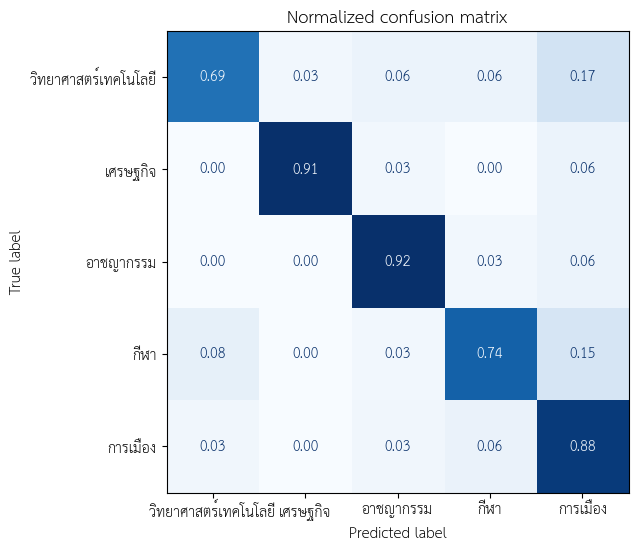

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

Label_list = [label for i, label in label_class] 
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= set(labels))
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, np.array(tokenized_datasets['test']['label']), Label_list)

แสดง Confusion matrix ผลลัพธืที่ได้จากการทำนาย จะเห็นได้ว่าหมวดหมู่เกี่ยวกับเทคโนโลยีทำนายได้ผลลัพธืที่ไม่ค่อยดีเทียบกับอื่นๆ

# Pineline in Huggingface 

หลังจากที่ทำการฝึกโมเดลเสร็จเรียบร้อย เราได้ระบุให้ทำการ deploy โมเดลลงใน huggingface hub เพื่อใช้งานและสามารถดึงไปใช้เป็น API ได้

In [ ]:
from transformers import pipeline

model_id = "SiraH/wangchanberta-base-att-spm-uncased-finetuned-ThainewsPBS"
pipe = pipeline("text-classification", model=model_id, device=0 , tokenizer="airesearch/wangchanberta-base-att-spm-uncased")

In [ ]:
def preprocessing_text_bf_pred(text):
    text = text.strip().lower().replace('"', '')
    text = word_tokenize(text, engine = "newmm")
    text = [i for i in text if i not in stopwords]
    text = ''.join(text)
    return text

ทดลองใส่ประโยคตัวอย่างที่ต้องการจำแนก

In [ ]:
context = input() #ใส่ประโยคตัวอย่าง

 สมาคมค้าทองคำรายงานว่า "ราคาทองวันนี้" วันพุธที่ 3 พฤษภาคม 2566 เวลา 09:25 น. เปิดตลาดครั้งที่ 1 ราคาทองเพิ่มขึ้น 300 บาท


In [ ]:
preprocessing_text_bf_pred(context)

'สมาคมค้าทองคำรายงานราคาทองพุธ3พฤษภาคม2566เวลา09:25น.ตลาด1ราคาทองเพิ่มขึ้น300บาท'

In [ ]:
preds = pipe(context, return_all_scores=True)

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
preds[0]

[{'label': 'LABEL_0', 'score': 0.024416135624051094},
 {'label': 'LABEL_1', 'score': 0.042620740830898285},
 {'label': 'LABEL_2', 'score': 0.06392702460289001},
 {'label': 'LABEL_3', 'score': 0.05167590081691742},
 {'label': 'LABEL_4', 'score': 0.8173602223396301}]

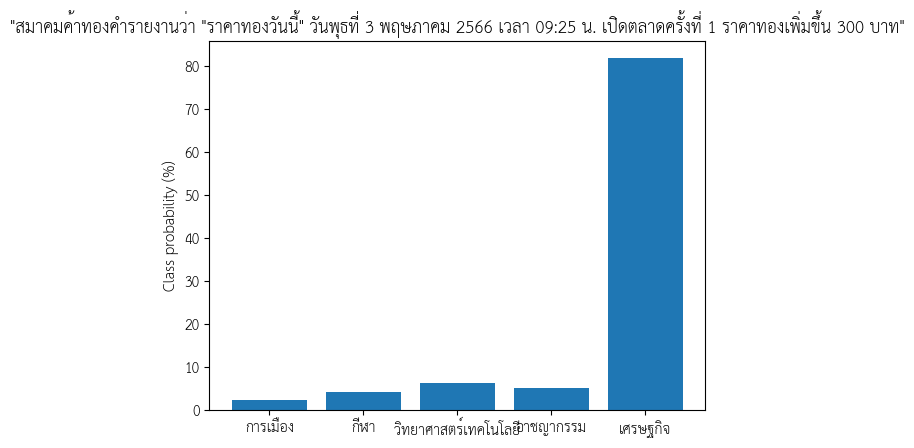

In [ ]:
label = Label_list
preds_df = pd.DataFrame(preds[0])
plt.bar(label, 100 * preds_df["score"], color='C0')
plt.title(f'"{context}"')
plt.ylabel("Class probability (%)")
plt.show()

ผลลัพธ์ที่ได้จากการทำนายจะแสดงดังรูปภาพด้านบน

# Future Working 
เราสามารถทำให้โมเดลมีประสิทธิภาพมากขึ้นด้วยวิธีการ
- ปรับจูนพารามิเตอร์ด้วย hyperparameter search ทำการค้นหาพารามิเตอร์ที่ดีที่สุด แต่จะกินทรัพยากรมาก
- เพิ่มจำนวนรอบการ train หรือใส่ schedule เข้าไปในการ train 
- เพิ่มจำนวนขนาดของข้อมูล 
- ทดลองไม่ตัด stopword ออก ในบางงานคำที่อยู่ใน list ของ stopword อาจมีความสำคัญ และด้วยโมเดล pre-trian ส่วนใหญ่มีจุดประสงค์ที่ออกแบบมาเพื่อต้องสามารถคำนวณความน่าจะเป็นจากตัวสตริงใดๆได้ “a general language model (LM) should be able to compute the probability of (and also generate) any string”. (https://arxiv.org/pdf/2009.04968.pdf) 


สามารถทดสอบได้ที่ https://huggingface.co/SiraH/wangchanberta-base-att-spm-uncased-finetuned-ThainewsPBS

### ศิระ หฤทัยปรีย์